In [31]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import pprint

# To Do
- include bb and rexp
- display buttons in visualization
- create multicolor lines (https://matplotlib.org/examples/pylab_examples/multicolored_line.html)
    - Zeit durch Alpha-Wert codieren
- decrease image saturation to improve line visibility
- verweildauer (zeit bis zum nächsten Datenpunkt) codieren - Größe des Punktes?

In [50]:
def find_file(suffix, path):
    """
    return the filename of the log file
    """
    result_files = []
    for root, dirs, files in os.walk(path):
        for file in [f for f in files if f.endswith(suffix)]:
            result_files.append(file)
    return result_files
        
def read_file(path):
    """
    return content of log file
    """
    with open(path) as raw_jfile:
        content = json.load(raw_jfile)
        return content
    
def crop_list(lst):
    """
    remove entries from log file before the game starts and after the game is finished
    return cropped file as list
    """
    sub_lst = []
    for entry in lst:
        try:
            if entry["msg"] == "Game started!":
                sub_lst = lst[lst.index(entry):]
            if "no images left" in entry["msg"].lower() and entry["user"]["name"]=="ImageClick_Main":
                sub_lst = lst[:lst.index(entry)+1]
        except:
            pass
    return sub_lst

def images_in_log(file):
    """
    split log file on new_image commands
    return list containing one section for each image in log file, 
    each of them starting with a new_image command
    """
    file = crop_list(file)
    images = []
    i = False
    i_prev = False
    for entry in [e for e in file if e["type"] == "attribute_updated" and e["id"] == "current-image"]:
        if i:
            i_prev = i
            i = file.index(entry)
            images.append(file[i_prev:i])
            #pprint.pprint(file[i_prev:i])
        else:
            i = file.index(entry)
    images.append(file[i:]) # slice from last new_image to end of file
    return images

def clean_pos_data (coords, firstclick, lastclick):
    sortedout = []
    # print ("first mouse click:", firstclick)
    # print ("last mouse click:", lastclick)
    # print ("inital number of coordinates:", len(coords))
    for i in coords:
        if i["timestamp"] < firstclick["timestamp"] or i["timestamp"] > lastclick["timestamp"]:
            # print (i)
            sortedout.append(i)
    included = [i for i in coords if i not in sortedout]
    # print ("resulting number of coordinates:", len(included), len(sortedout))
    return included, sortedout

def image_data(img_slice):
    """
    extract image filename and tracking coordinates from img section in log file
    """
    buttons = ["#reportButton", "#replayButton"]
    coordinates = []
    clicks=[]
    button_clicks = []
    last_click = 0
    filename = ""
    for entry in img_slice:
        try: 
            if entry["type"]=="attribute_updated" and entry["id"] == "current-image":
                filename = entry["value"].split("/")[-1]
            if entry["type"]=="mouse_positions":
                coordinates = entry["data"]                
            if entry["type"]=="mouse_click" and entry["data"]["element"]=="#current-image":
                clicks.append(entry["data"]["coordinates"])
                last_click = entry["data"]
            if entry["data"]["element"]=="#overlayButton":
                first_click = entry["data"]
            if entry["type"]=="mouse_click" and entry["data"]["element"] in buttons:
                button_clicks.append(entry["data"]["coordinates"])
        except: 
            pass
    coordinates, sortout = clean_pos_data(coordinates, first_click, last_click) 
    return filename,coordinates,sortout,clicks,button_clicks

def plot_mouse(img):
    """
    extract filnames and coordinates from image section, plot image and mouse movement
    """
    filename,tracking_coords,tracking_sortout,clicks,button_clicks,=image_data(img)
    if filename == "" or len(tracking_coords) == 0:
        print ("Missing Data in file", filename)
        return
    xtracking,ytracking = [],[]
    xsortout,ysortout = [],[]
    xclicks,yclicks = [],[]
    xbuttons,ybuttons=[],[]
    print ("number of coordinates to be processed:", len(tracking_coords))
    for i in tracking_coords:
        xtracking.append(i["x"])
        ytracking.append(i["y"])
    for i in tracking_sortout:
        xsortout.append(i["x"])
        ysortout.append(i["y"])
    for i in clicks:
        xclicks.append(i["x"])
        yclicks.append(i["y"])
    for i in button_clicks:
        xbuttons.append(i["x"])
        ybuttons.append(i["y"])
    fig, ax = plt.subplots()
    fig.set_size_inches(10,20)
    imshow = ax.imshow(plt.imread("images/"+filename))
    plt.plot(xtracking,ytracking, color='blue', marker='o', linestyle='dashed', linewidth=1, markersize=5)
    #plt.plot(xsortout,ysortout, color='yellow', marker='o', linestyle='dashed', linewidth=1, markersize=7)
    if len(xclicks)>0:
        plt.plot(xclicks[-1],yclicks[-1], color='green', marker='+', markersize=50)
        if len(xclicks)>1:
            plt.plot(xclicks[:-1],yclicks[:-1], color='red', marker='+', markersize=30, linestyle='none')        
    plt.plot(xbuttons,ybuttons,color="red",marker="o",markersize=10,linestyle='none')

In [3]:
os.chdir(os.getcwd()+"/data/")
cwd = os.getcwd()
files = find_file(".log", cwd)
print (files)

['2019-04-10 16-34-21-meetup 1.log']


image 0
number of coordinates to be processed: 85
image 1
number of coordinates to be processed: 99
image 2
number of coordinates to be processed: 127
image 3
number of coordinates to be processed: 115
image 4
number of coordinates to be processed: 74
image 5
number of coordinates to be processed: 54
image 6
number of coordinates to be processed: 97
image 7
number of coordinates to be processed: 132
image 8
number of coordinates to be processed: 89
image 9
number of coordinates to be processed: 87
image 10
number of coordinates to be processed: 33
image 11
number of coordinates to be processed: 39
image 12
number of coordinates to be processed: 48
image 13
number of coordinates to be processed: 32
image 14
number of coordinates to be processed: 82


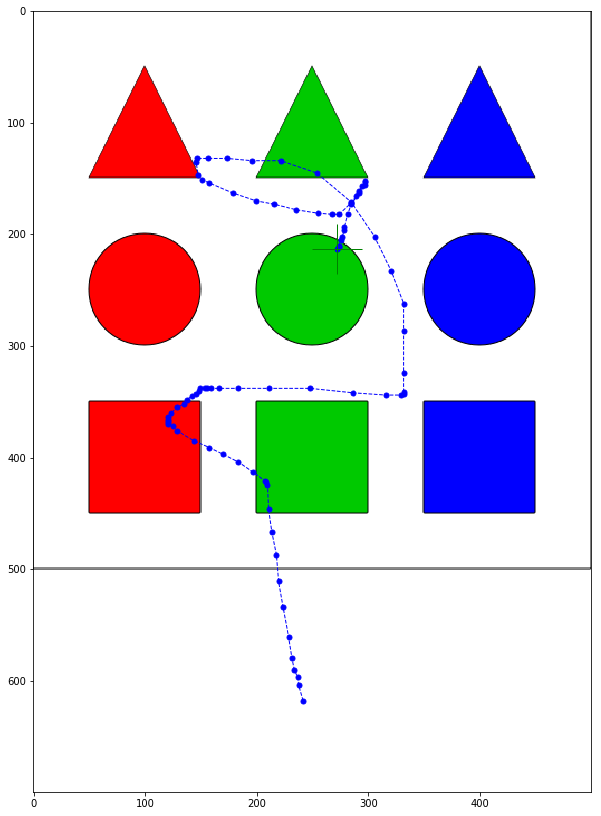

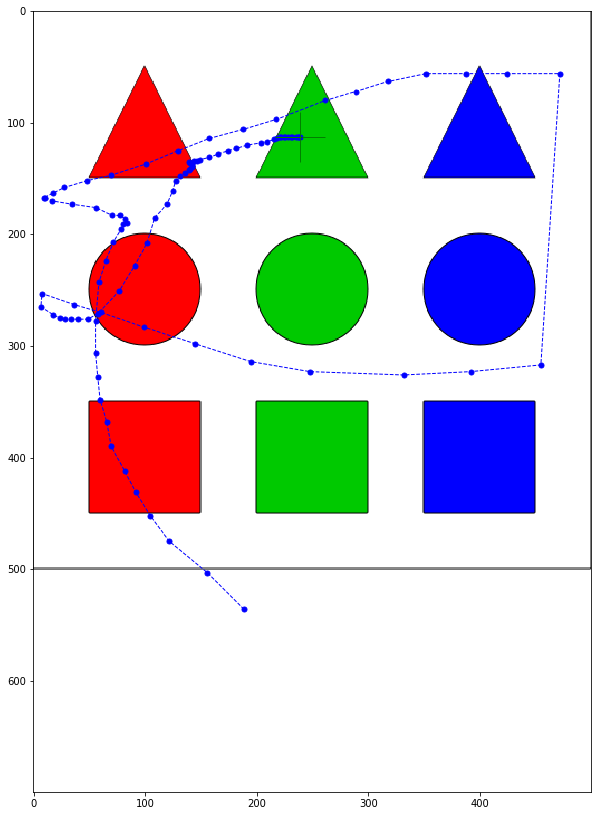

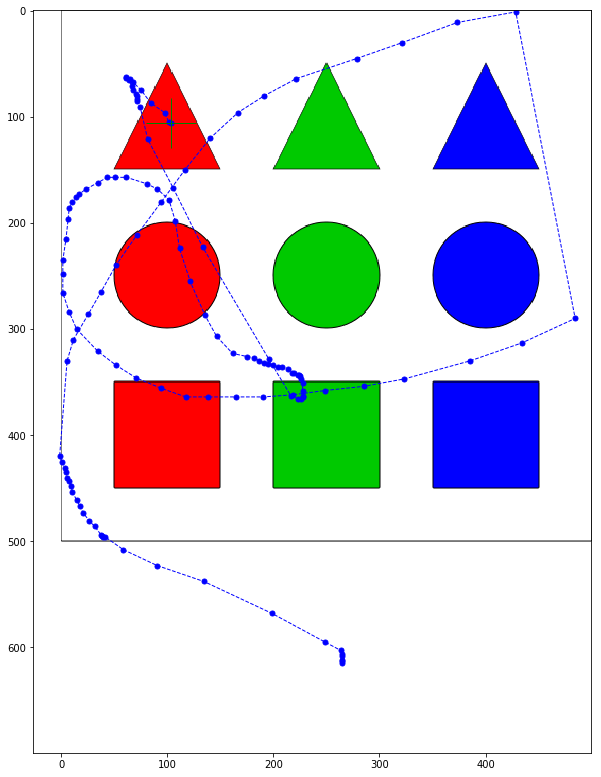

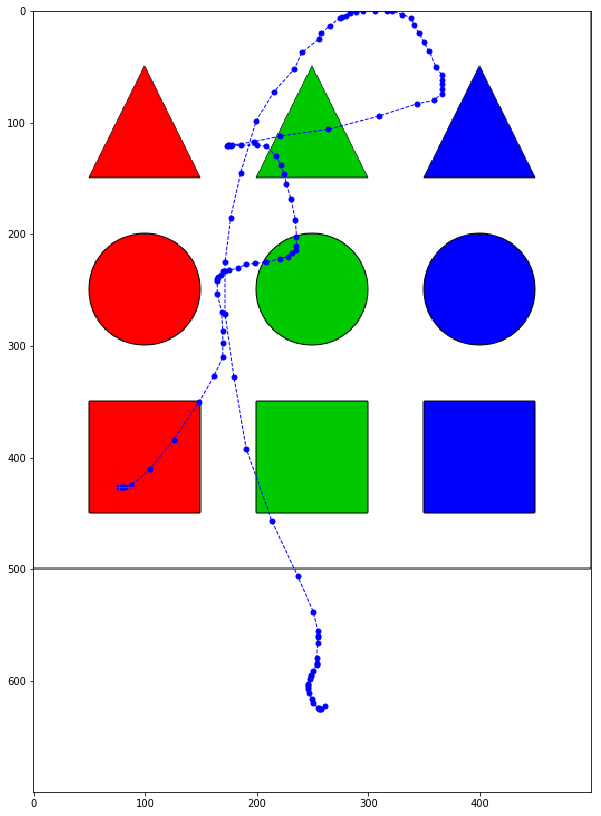

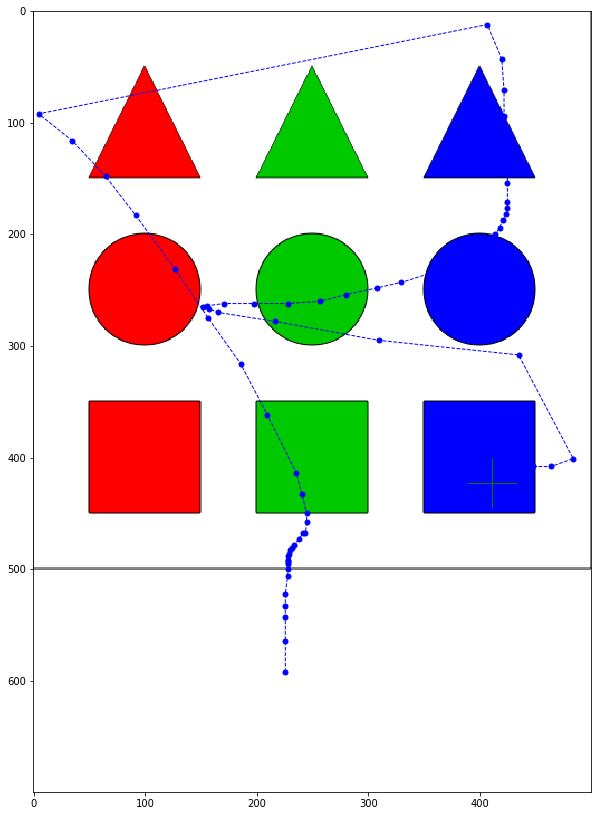

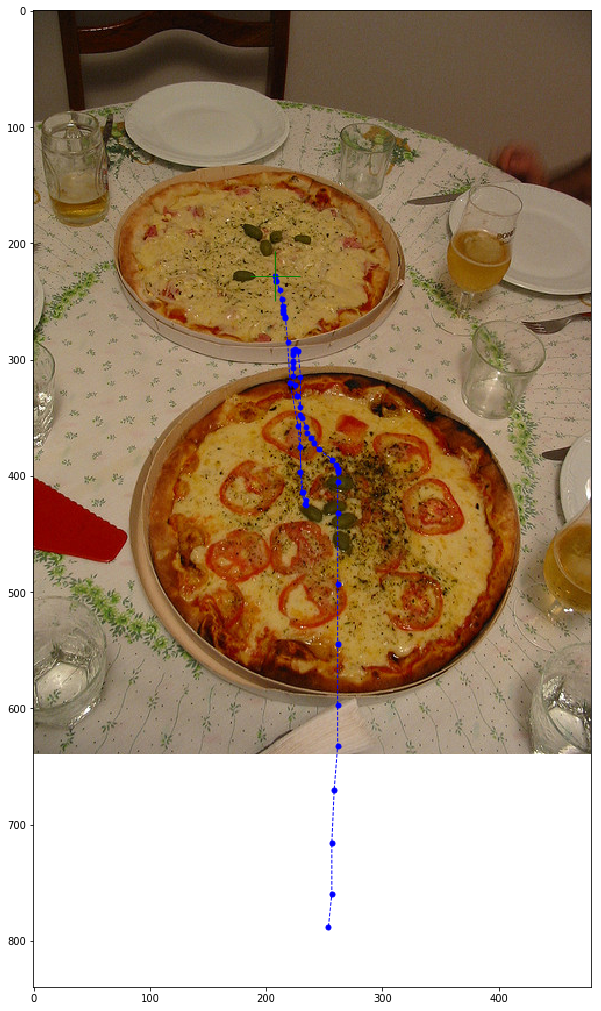

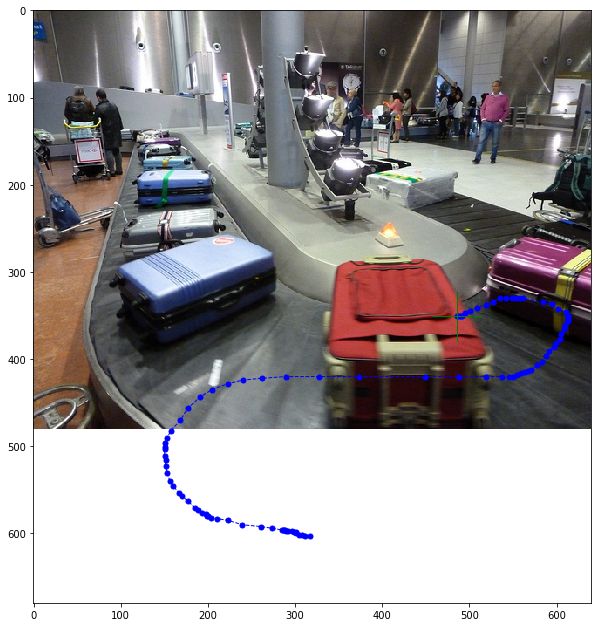

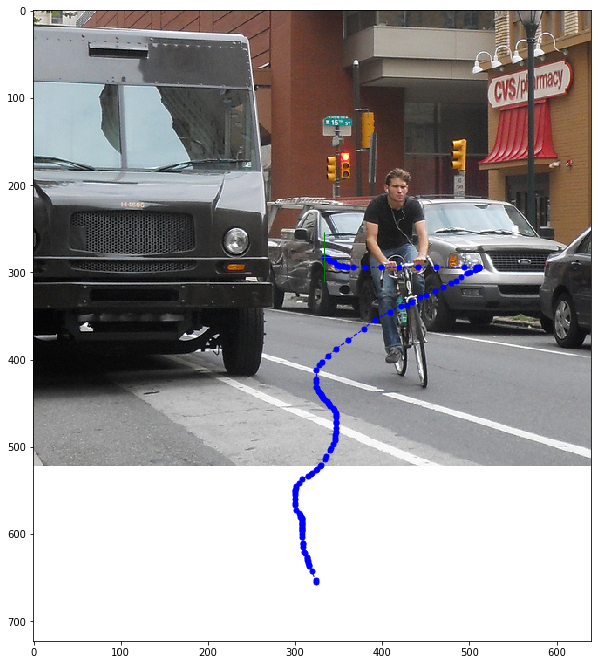

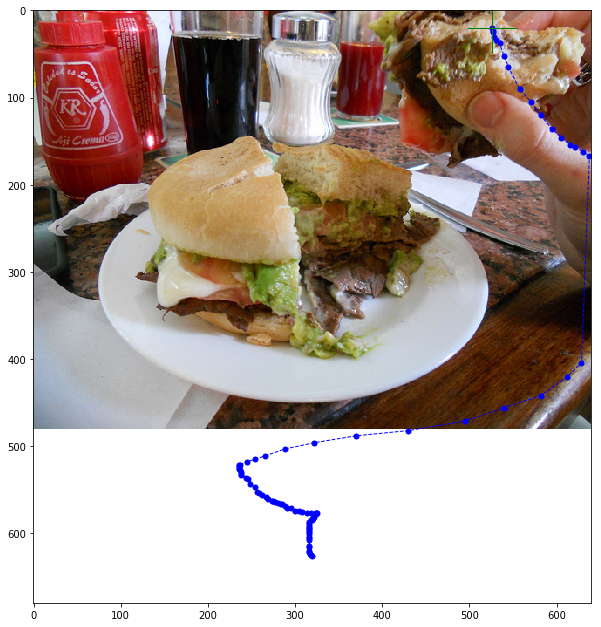

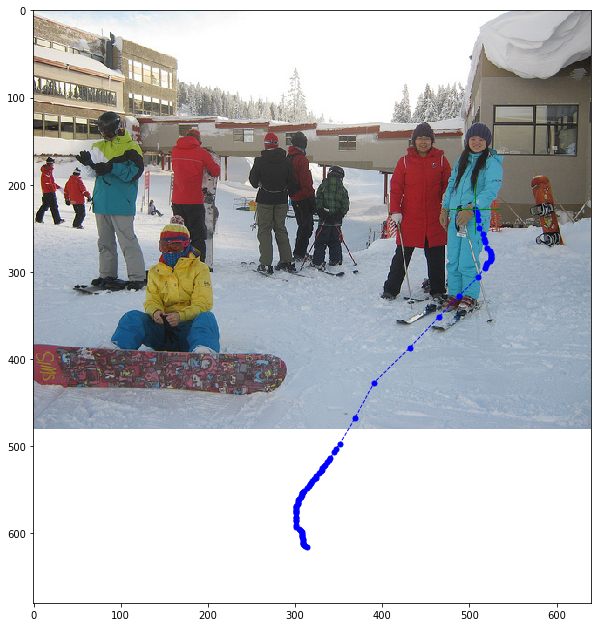

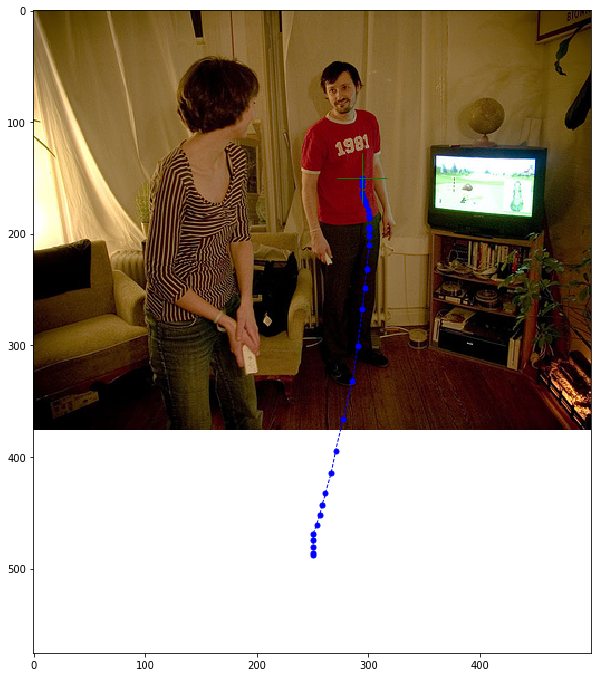

In [52]:
for f in files:
    log_file = read_file(f)
    y = 0
    for i in images_in_log(log_file):
        print ("image",y)
        plot_mouse(i)
        y += 1